In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import patsy

## Auto data set

In [4]:
auto = pd.read_csv('../data/Auto.csv', na_values='?').dropna()
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


### Validation set approach

1. The validation set approach involves randomly dividing the training data into two sets: a training set and a validation set.
2. A model is fit on the training set and validation set score (either MSE or mis-classification ratio) is computed.

In the absence of test set, validation set score is used as an estimate for the model's test set performance.

In [7]:
from sklearn.model_selection import ShuffleSplit, KFold, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [24]:
rs = ShuffleSplit(n_splits=10, test_size=.5, random_state=42)
valid_mse = []
degree = np.arange(1,11)
for train_idx, valid_idx in rs.split(auto):
    deg_mse = []
    X_train = (auto['horsepower'].iloc[train_idx]).values.reshape(-1, 1)
    y_train = auto['mpg'].iloc[train_idx]
    X_valid = (auto['horsepower'].iloc[valid_idx]).values.reshape(-1, 1)
    y_valid = auto['mpg'].iloc[valid_idx]
    for deg in degree:
        poly = PolynomialFeatures(degree=deg, include_bias=False)   
        X_poly = poly.fit_transform(X_train)
        lin_reg = LinearRegression()
        lin_reg.fit(X_poly, y_train)
        
        X_valid_poly = poly.transform(X_valid)
        deg_mse.append(mean_squared_error(y_valid, lin_reg.predict(X_valid_poly)))
    valid_mse.append(deg_mse)

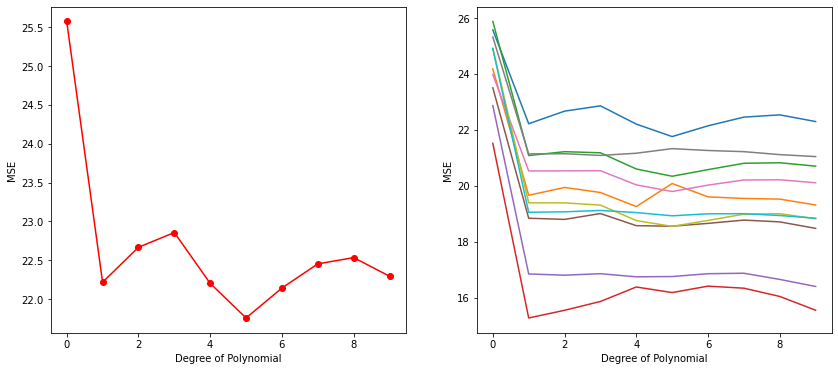

In [28]:
fig, ax = plt.subplots(1,2, figsize=(14, 6))

ax[0].plot(valid_mse[0], 'r-o')
ax[0].set_xlabel('Degree of Polynomial')
ax[0].set_ylabel('MSE')

for i in range(len(valid_mse)):
    ax[1].plot(valid_mse[i])
ax[1].set_xlabel('Degree of Polynomial')
ax[1].set_ylabel('MSE')

plt.show();

#### Drawbacks of validation set approach:
1. High variance in the estimates, because of random splitting of observations into two sets. Which observations fall into which set tend to influence the scores. This can be see in the right hand panel of the above figure.
2. Since the model trains on only half the observations, it is high-bias.

## Leave-One-Out Cross-validation

As the name suggests, one observation is left out, training the model on n-1 observations. The left out observation is then used to estimate test set error. This process is repeated n times, each time with a different observation in the validation set. The test set error is then the mean of the n validation errors.

ADVANTAGES:
1. Since n-1 observations are used in training the model, loocv is low-bias.
2. It isn't random. Each of the n obsevations appear once in the validation set.

DISADVANTAGES:
1. Since we have to train n times, it can be computationally intensive, especially if n is large or if each model takes a long time to train.

![leave-on-out cv](../figures/leave_one_out_cv.jpg)

In [29]:
from sklearn.model_selection import LeaveOneOut

Text(0, 0.5, 'MSE')

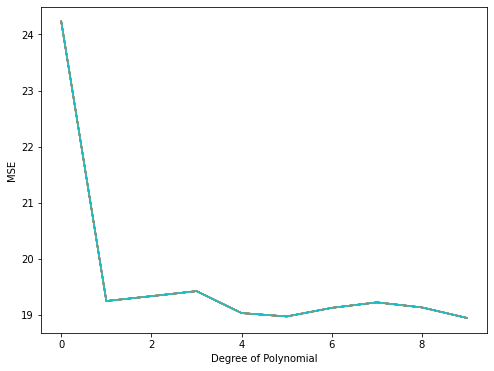

In [45]:
n_iterations = 1 # was planning to prove the variablility in loocv with n_iterations = 10
                 # however, with the current code setup below, all the iterations are same
                 # revisit this soem time later. # TODO
iter_mse = []
for i in range(n_iterations):
    deg_mse = []
    for deg in degree:
        loo_mse = []
        for train_idx, valid_idx in LeaveOneOut().split(auto):
            X_train = auto.iloc[train_idx][['horsepower']]
            y_train = auto.iloc[train_idx][['mpg']]
            X_valid = auto.iloc[valid_idx][['horsepower']]
            y_valid = auto.iloc[valid_idx][['mpg']]

            poly_trans = PolynomialFeatures(degree=deg)
            X_train_poly = poly_trans.fit_transform(X_train)
            X_valid_poly = poly_trans.fit_transform(X_valid)

            lin_reg = LinearRegression()
            lin_reg.fit(X_train_poly, y_train)
            loo_mse.append(mean_squared_error(y_valid, lin_reg.predict(X_valid_poly)))

        deg_mse.append(np.mean(loo_mse))
    iter_mse.append(deg_mse)

fig, ax = plt.subplots(1,1, figsize=(8, 6))
for i in range(n_iterations):
    ax.plot(iter_mse[i])
ax.set_xlabel('Degree of Polynomial')
ax.set_ylabel('MSE')

### k-fold cross-validation

divide the observations RANDOMLY into k groups/folds of approx. equal size, train on k-1 folds and use the remaining one fold as a held out or validation set. Repeat this process k times, with each of the k folds used as a validation set once.

ADVANTAGES:
1. requires running the model k times (vs. n times for loocv), so less computationally intensive.
2. trains on (k-1)n/k observations, so less bias than validation set approach, but more than loocv.
3. both k-fold and loocv provide good estimates of test set error values.

![title](../figures/kfold_cv.jpg)

In [41]:
from sklearn.model_selection import KFold

Text(0, 0.5, 'MSE')

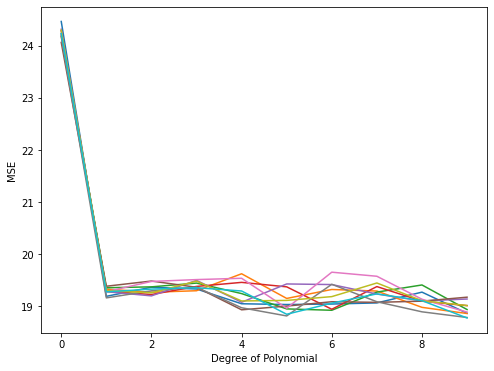

In [44]:
n_iterations = 10
iter_mse = []
for i in range(n_iterations):
    deg_mse = []
    for deg in degree:
        loo_mse = []
        kf = KFold(n_splits=10, shuffle=True)
        for train_idx, valid_idx in kf.split(auto):
            X_train = auto.iloc[train_idx][['horsepower']]
            y_train = auto.iloc[train_idx][['mpg']]
            X_valid = auto.iloc[valid_idx][['horsepower']]
            y_valid = auto.iloc[valid_idx][['mpg']]

            poly_trans = PolynomialFeatures(degree=deg)
            X_train_poly = poly_trans.fit_transform(X_train)
            X_valid_poly = poly_trans.fit_transform(X_valid)

            lin_reg = LinearRegression()
            lin_reg.fit(X_train_poly, y_train)
            loo_mse.append(mean_squared_error(y_valid, lin_reg.predict(X_valid_poly)))

        deg_mse.append(np.mean(loo_mse))
    iter_mse.append(deg_mse)

fig, ax = plt.subplots(1,1, figsize=(8, 6))
for i in range(n_iterations):
    ax.plot(iter_mse[i])
ax.set_xlabel('Degree of Polynomial')
ax.set_ylabel('MSE')

### cross-validation uses:

When we perform cross-validation, our goal might be to determine how
well a given statistical learning procedure can be expected to perform on
independent data; in this case, the actual estimate of the test MSE is
of interest. But at other times we are interested only in the location of
the minimum point in the estimated test MSE curve. This is because we
might be performing cross-validation on a number of statistical learning
methods, or on a single method using different levels of flexibility, in order
to identify the method that results in the lowest test error. For this purpose,
the location of the minimum point in the estimated test MSE curve is
important, but the actual value of the estimated test MSE is not. We find
in Figure 5.6 that despite the fact that they sometimes underestimate the
true test MSE, all of the CV curves come close to identifying the correct
level of flexibility—that is, the flexibility level corresponding to the smallest
test MSE.

![cv_1](../figures/cv_1.jpg)